# Dataset Sample Visualization (Color Version)

This notebook displays random samples from each class in the 5-channel 32x32 PCAP dataset using color visualization (viridis colormap).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
from typing import List, Dict

In [2]:
# Debug: Let's examine the actual data structure first
sample_file = "/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32/Benign_Final/train/shard_00000.parquet"
debug_df = pd.read_parquet(sample_file)

print("Dataset shape:", debug_df.shape)
print("Columns:", len(debug_df.columns), "columns")
print("First few column names:", debug_df.columns.tolist()[:10])
print("Data types:", debug_df.dtypes.value_counts())

# Check the actual values
first_row = debug_df.iloc[0]
print(f"\nFirst row shape: {first_row.shape}")
print(f"First row type: {type(first_row)}")
print(f"Sample values: {first_row.iloc[:10].tolist()}")

# Check for non-numeric columns
non_numeric = debug_df.select_dtypes(exclude=[np.number])
numeric_cols = debug_df.select_dtypes(include=[np.number]).columns
print(f"\nNon-numeric columns: {non_numeric.columns.tolist()}")
print(f"Numeric columns count: {len(numeric_cols)}")

if len(numeric_cols) == 5120:
    print("✓ Data is 5-channel 32x32 (5120 features)")
elif len(numeric_cols) == 1024:
    print("✓ Data is single-channel 32x32 (1024 features)")
else:
    print(f"⚠ Unexpected feature count: {len(numeric_cols)}")

Dataset shape: (1000, 8)
Columns: 8 columns
First few column names: ['sample_id', 'label', 'image_format', 'image_data', 'height', 'width', 'channels', 'payload_bytes']
Data types: object    5
int64     3
Name: count, dtype: int64

First row shape: (8,)
First row type: <class 'pandas.core.series.Series'>
Sample values: ['Benign_Final_000000', 'Benign_Final', '5channel_32x32', array([0.27058825, 0.27058825, 0.09090909, ..., 0.36363637, 0.        ,
       0.04705882], shape=(5120,)), np.int64(32), np.int64(32), np.int64(5), array([ 69, 160,  11, ..., 188,  86, 131], shape=(1500,))]

Non-numeric columns: ['sample_id', 'label', 'image_format', 'image_data', 'payload_bytes']
Numeric columns count: 3
⚠ Unexpected feature count: 3


In [3]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Dataset path
dataset_path = "/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32"

# Get all class directories
class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print(f"Found {len(class_dirs)} classes:")
for i, class_name in enumerate(class_dirs, 1):
    print(f"{i}. {class_name}")

Found 9 classes:
1. Recon-PortScan
2. DictionaryBruteForce
3. DoS-UDP_Flood
4. Mirai-udpplain
5. Benign_Final
6. SqlInjection
7. DDoS-SYN_Flood
8. DoS-TCP_Flood
9. DDoS-HTTP_Flood


In [4]:
def load_sample_data(class_name: str, num_samples: int = 10) -> pd.DataFrame:
    """
    Load random samples from a specific class - UPDATED to match ViT notebook structure
    """
    class_path = os.path.join(dataset_path, class_name)
    
    # Try to load from train directory first, then test, then val
    for split in ['train', 'test', 'val']:
        split_path = os.path.join(class_path, split)
        if os.path.exists(split_path):
            parquet_files = [f for f in os.listdir(split_path) if f.endswith('.parquet')]
            if parquet_files:
                # Load from first parquet file
                file_path = os.path.join(split_path, parquet_files[0])
                df = pd.read_parquet(file_path)
                
                # Check if 'image_data' column exists (like in ViT notebook)
                if 'image_data' in df.columns:
                    print(f"Found 'image_data' column in {class_name}")
                    # Sample random rows
                    if len(df) >= num_samples:
                        sampled_df = df.sample(n=num_samples, random_state=42)
                    else:
                        sampled_df = df
                        print(f"Warning: Only {len(df)} samples available for {class_name}, requested {num_samples}")
                    return sampled_df
                else:
                    print(f"No 'image_data' column found in {class_name}, checking structure...")
                    print(f"Columns: {df.columns.tolist()[:10]}")
                    # Assume all columns are features (fallback)
                    if len(df) >= num_samples:
                        sampled_df = df.sample(n=num_samples, random_state=42)
                    else:
                        sampled_df = df
                        print(f"Warning: Only {len(df)} samples available for {class_name}, requested {num_samples}")
                    return sampled_df
    
    print(f"Error: No parquet files found for class {class_name}")
    return pd.DataFrame()

In [5]:
def visualize_image_samples(data: np.ndarray, class_name: str, num_samples: int = 10):
    """
    Visualize image samples from a class - COLOR VERSION (viridis)
    """
    # Determine the number of samples to display
    actual_samples = min(num_samples, len(data))
    
    if actual_samples == 0:
        print(f"No data to visualize for {class_name}")
        return 0
    
    # Create subplot grid
    cols = 5
    rows = (actual_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    fig.suptitle(f'{class_name} - Random Samples (Averaged Color)', fontsize=16, fontweight='bold')
    
    # Handle case where we have only one row
    if rows == 1:
        if cols == 1:
            axes = np.array([[axes]])
        else:
            axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(actual_samples):
        row = i // cols
        col = i % cols
        
        # Get the image data
        sample = data[i]
        
        print(f"Sample {i+1}: {len(sample)} features")  # Debug info
        
        # Handle different data formats more robustly
        try:
            if len(sample) == 5120:  # 5 channels * 32 * 32
                # Reshape to (5, 32, 32) and take mean across channels for visualization
                image = sample.reshape(5, 32, 32).mean(axis=0)
            elif len(sample) == 1024:  # Single channel 32x32
                image = sample.reshape(32, 32)
            elif len(sample) >= 1024:
                # Use first 1024 values and reshape to 32x32
                image = sample[:1024].reshape(32, 32)
            else:
                # For very small arrays, pad with zeros to make a small square
                size = max(4, int(np.ceil(np.sqrt(len(sample)))))
                padded = np.zeros(size * size)
                padded[:len(sample)] = sample
                image = padded.reshape(size, size)
                
        except Exception as e:
            print(f"Error reshaping sample {i+1}: {e}")
            # Create a placeholder image
            image = np.zeros((8, 8))
            image[0, 0] = 1  # Add a marker
        
        axes[row, col].imshow(image, cmap='viridis', aspect='auto')
        axes[row, col].set_title(f'Sample {i+1}', fontsize=10)
        axes[row, col].axis('off')
    
    # Hide unused subplots
    for i in range(actual_samples, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return actual_samples

In [6]:
# Load and examine the structure of one sample file
sample_class = class_dirs[0]
sample_df = load_sample_data(sample_class, num_samples=1)

if not sample_df.empty:
    print(f"Sample data shape: {sample_df.shape}")
    print(f"Columns: {sample_df.columns.tolist()[:10]}...")  # Show first 10 columns
    print(f"Data types: {sample_df.dtypes.value_counts()}")
    
    # Check if there are any non-numeric columns (like labels)
    numeric_cols = sample_df.select_dtypes(include=[np.number]).columns
    non_numeric_cols = sample_df.select_dtypes(exclude=[np.number]).columns
    
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"Non-numeric columns: {len(non_numeric_cols)}")
    if len(non_numeric_cols) > 0:
        print(f"Non-numeric column names: {non_numeric_cols.tolist()}")

Found 'image_data' column in Recon-PortScan
Sample data shape: (1, 8)
Columns: ['sample_id', 'label', 'image_format', 'image_data', 'height', 'width', 'channels', 'payload_bytes']...
Data types: object    5
int64     3
Name: count, dtype: int64
Numeric columns: 3
Non-numeric columns: 5
Non-numeric column names: ['sample_id', 'label', 'image_format', 'image_data', 'payload_bytes']



Loading samples from class: Recon-PortScan
Found 'image_data' column in Recon-PortScan
Processing 'image_data' column for Recon-PortScan
Loaded 10 samples with 5120 features each
Reshaped to: (10, 5, 32, 32)


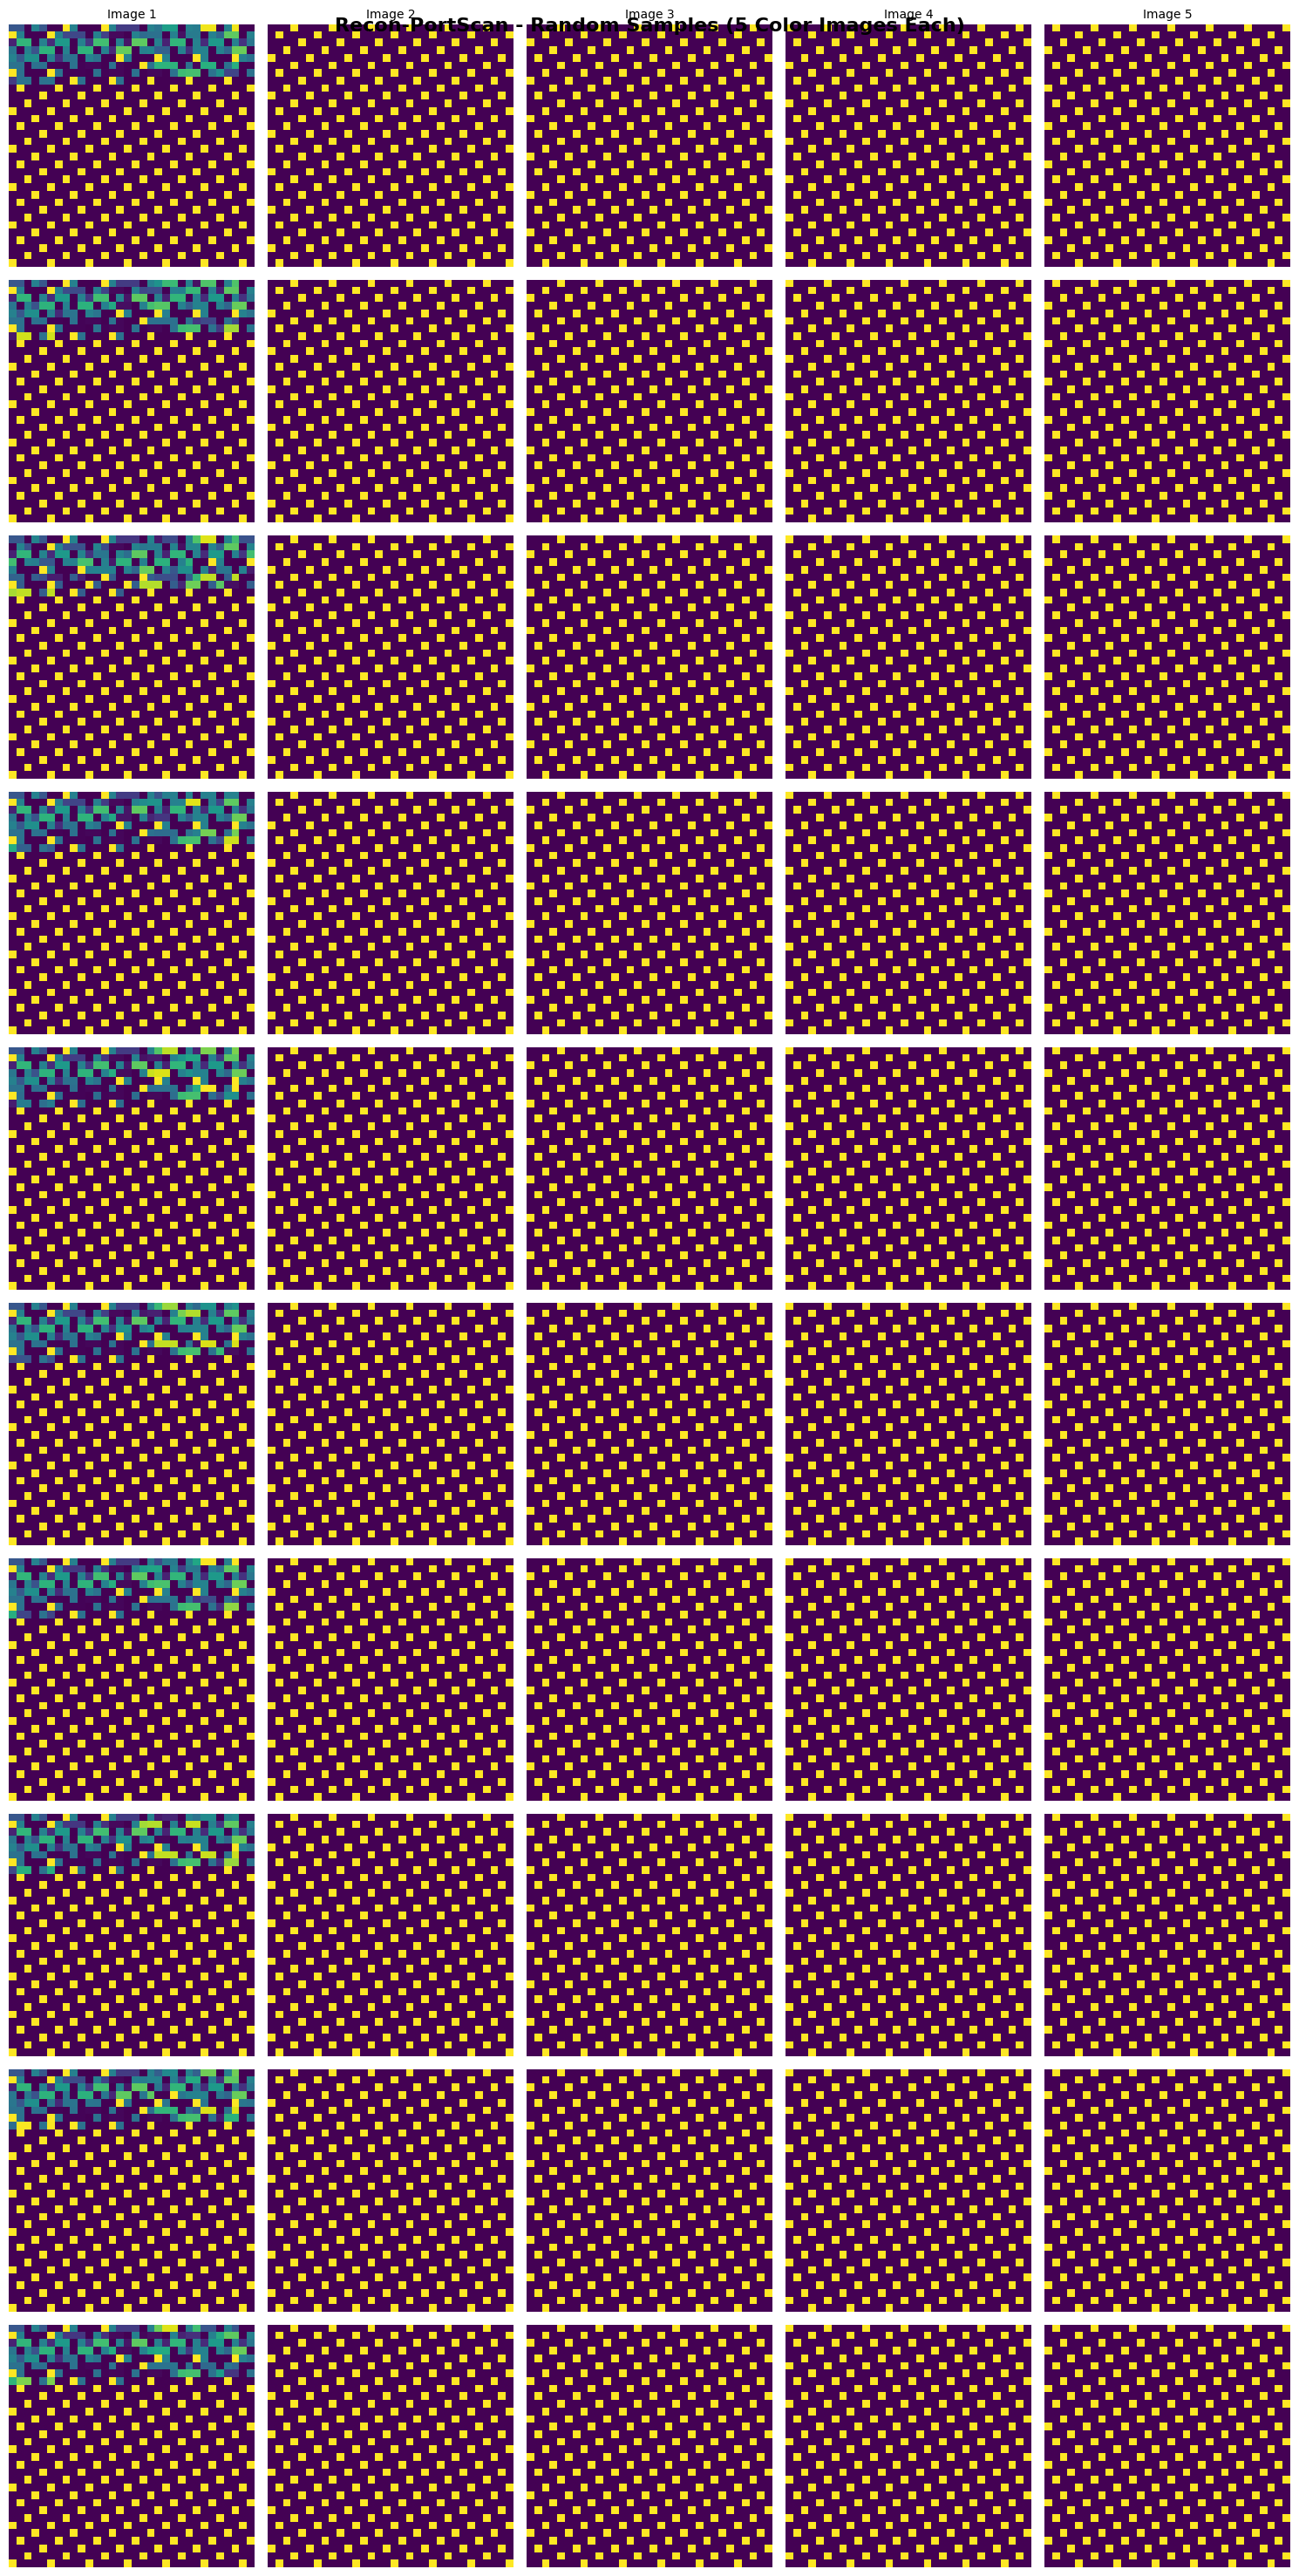

Displayed 10 samples with 5 color images each

Loading samples from class: DictionaryBruteForce
Found 'image_data' column in DictionaryBruteForce
Processing 'image_data' column for DictionaryBruteForce
Loaded 10 samples with 5120 features each
Reshaped to: (10, 5, 32, 32)


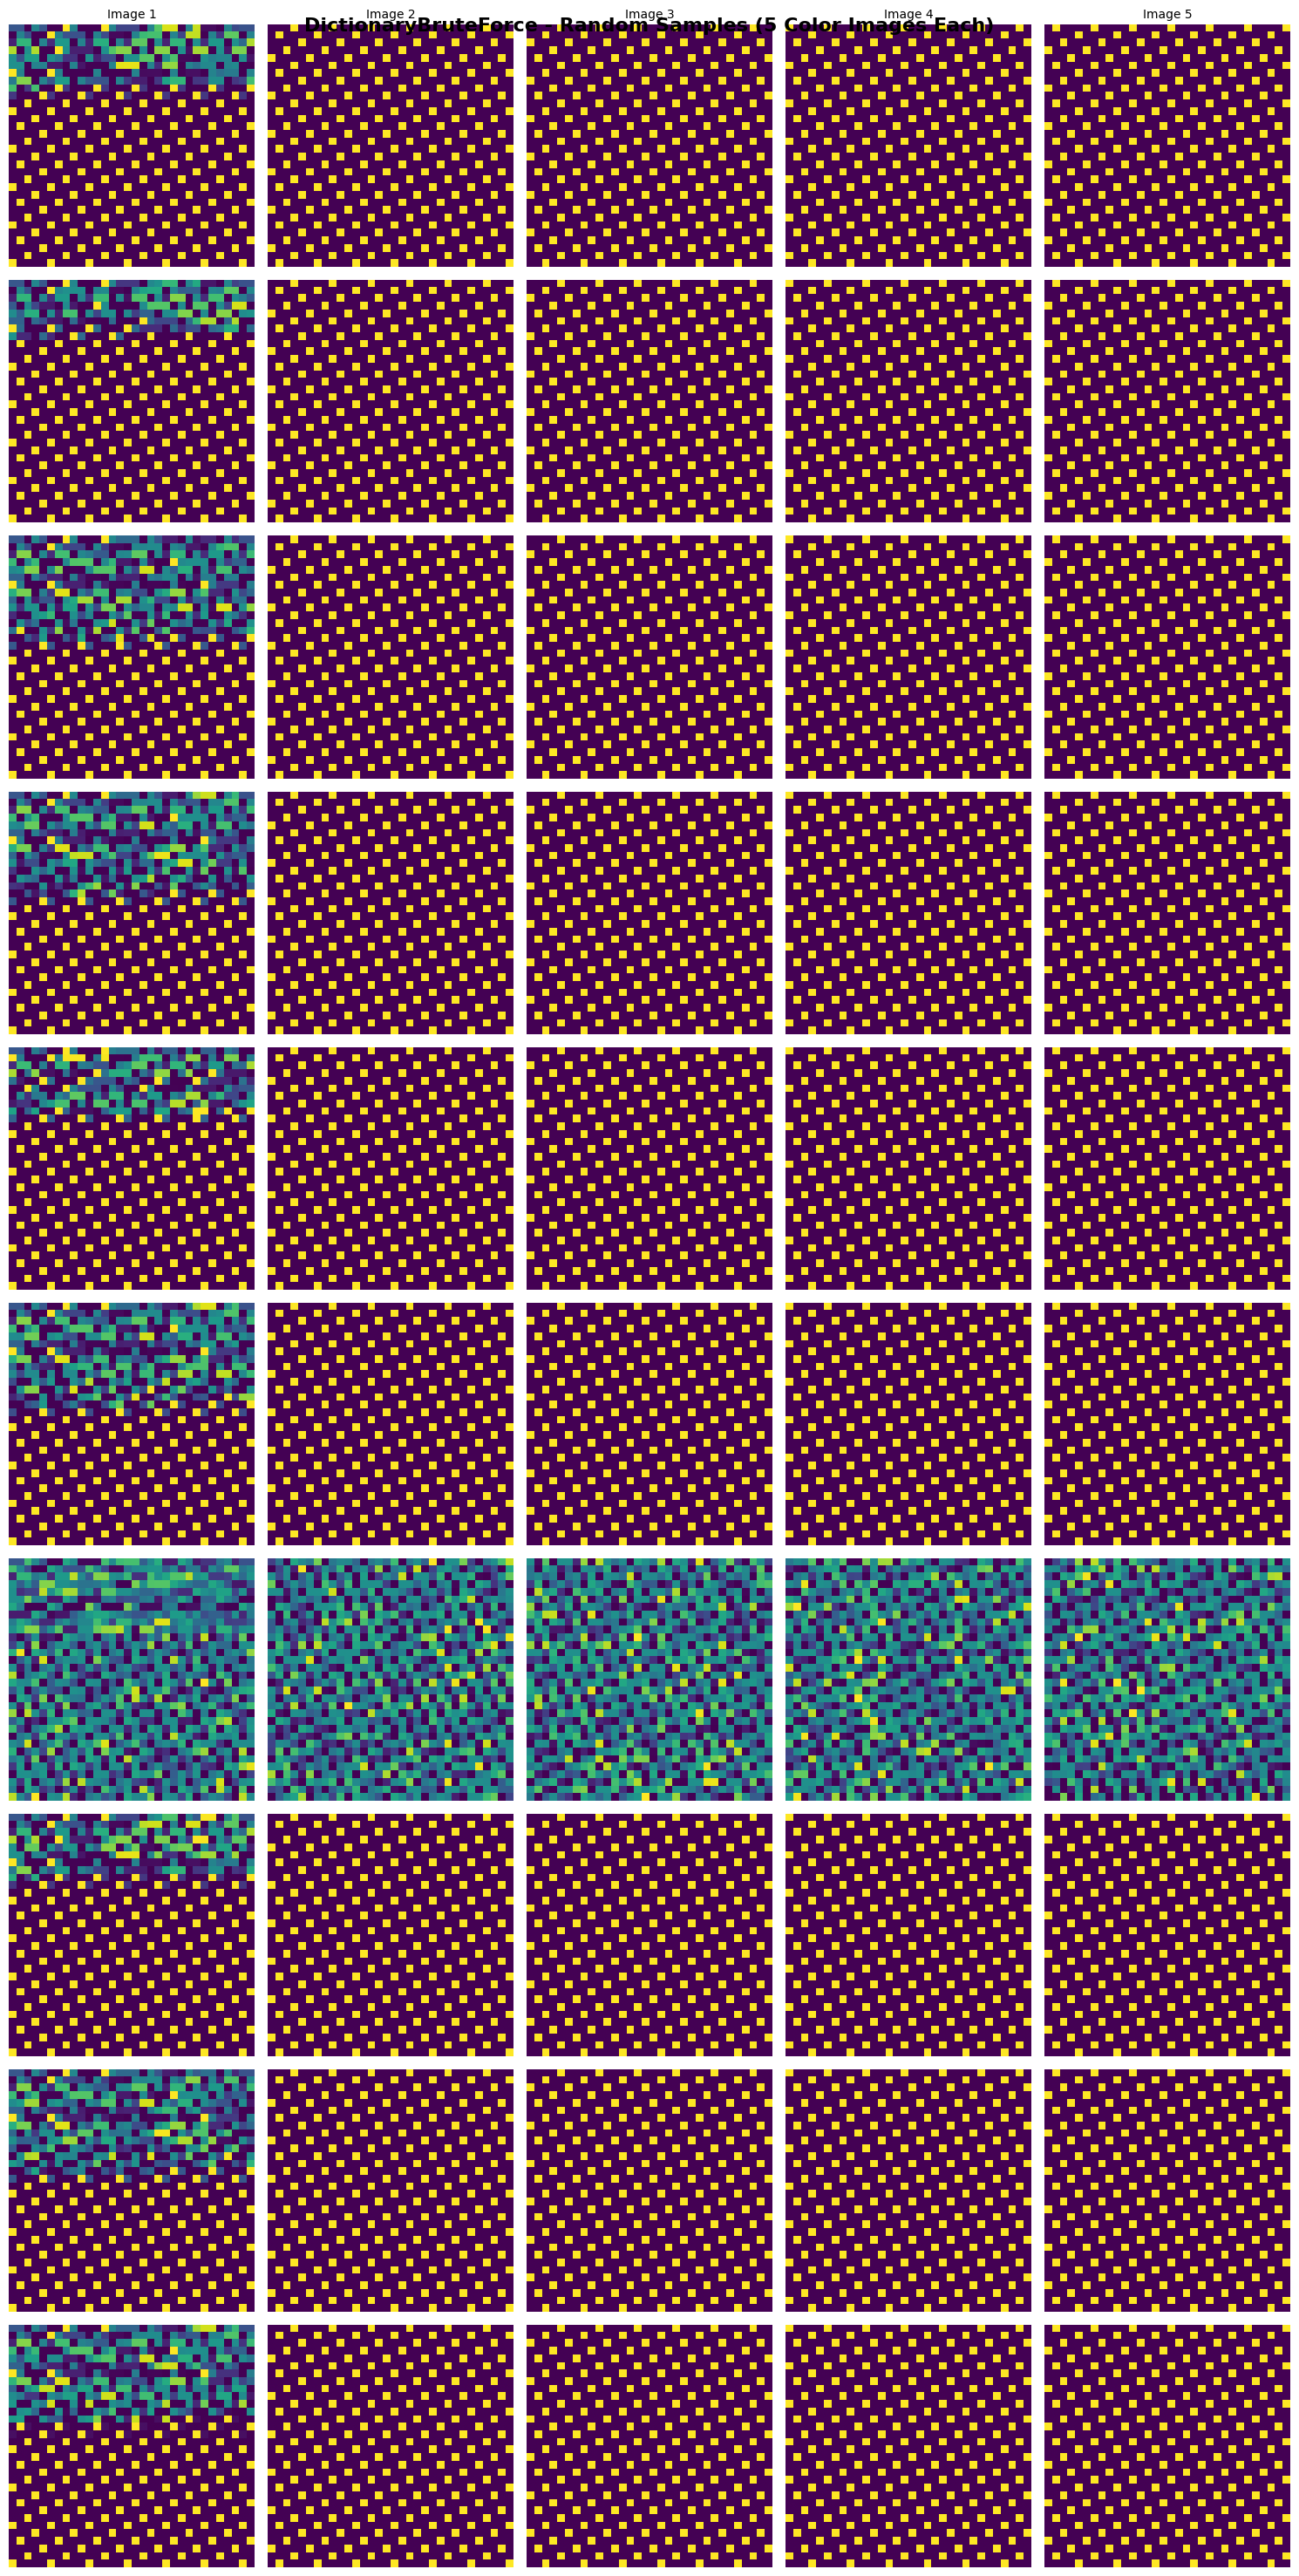

Displayed 10 samples with 5 color images each

Loading samples from class: DoS-UDP_Flood
Found 'image_data' column in DoS-UDP_Flood
Processing 'image_data' column for DoS-UDP_Flood
Loaded 10 samples with 5120 features each
Reshaped to: (10, 5, 32, 32)


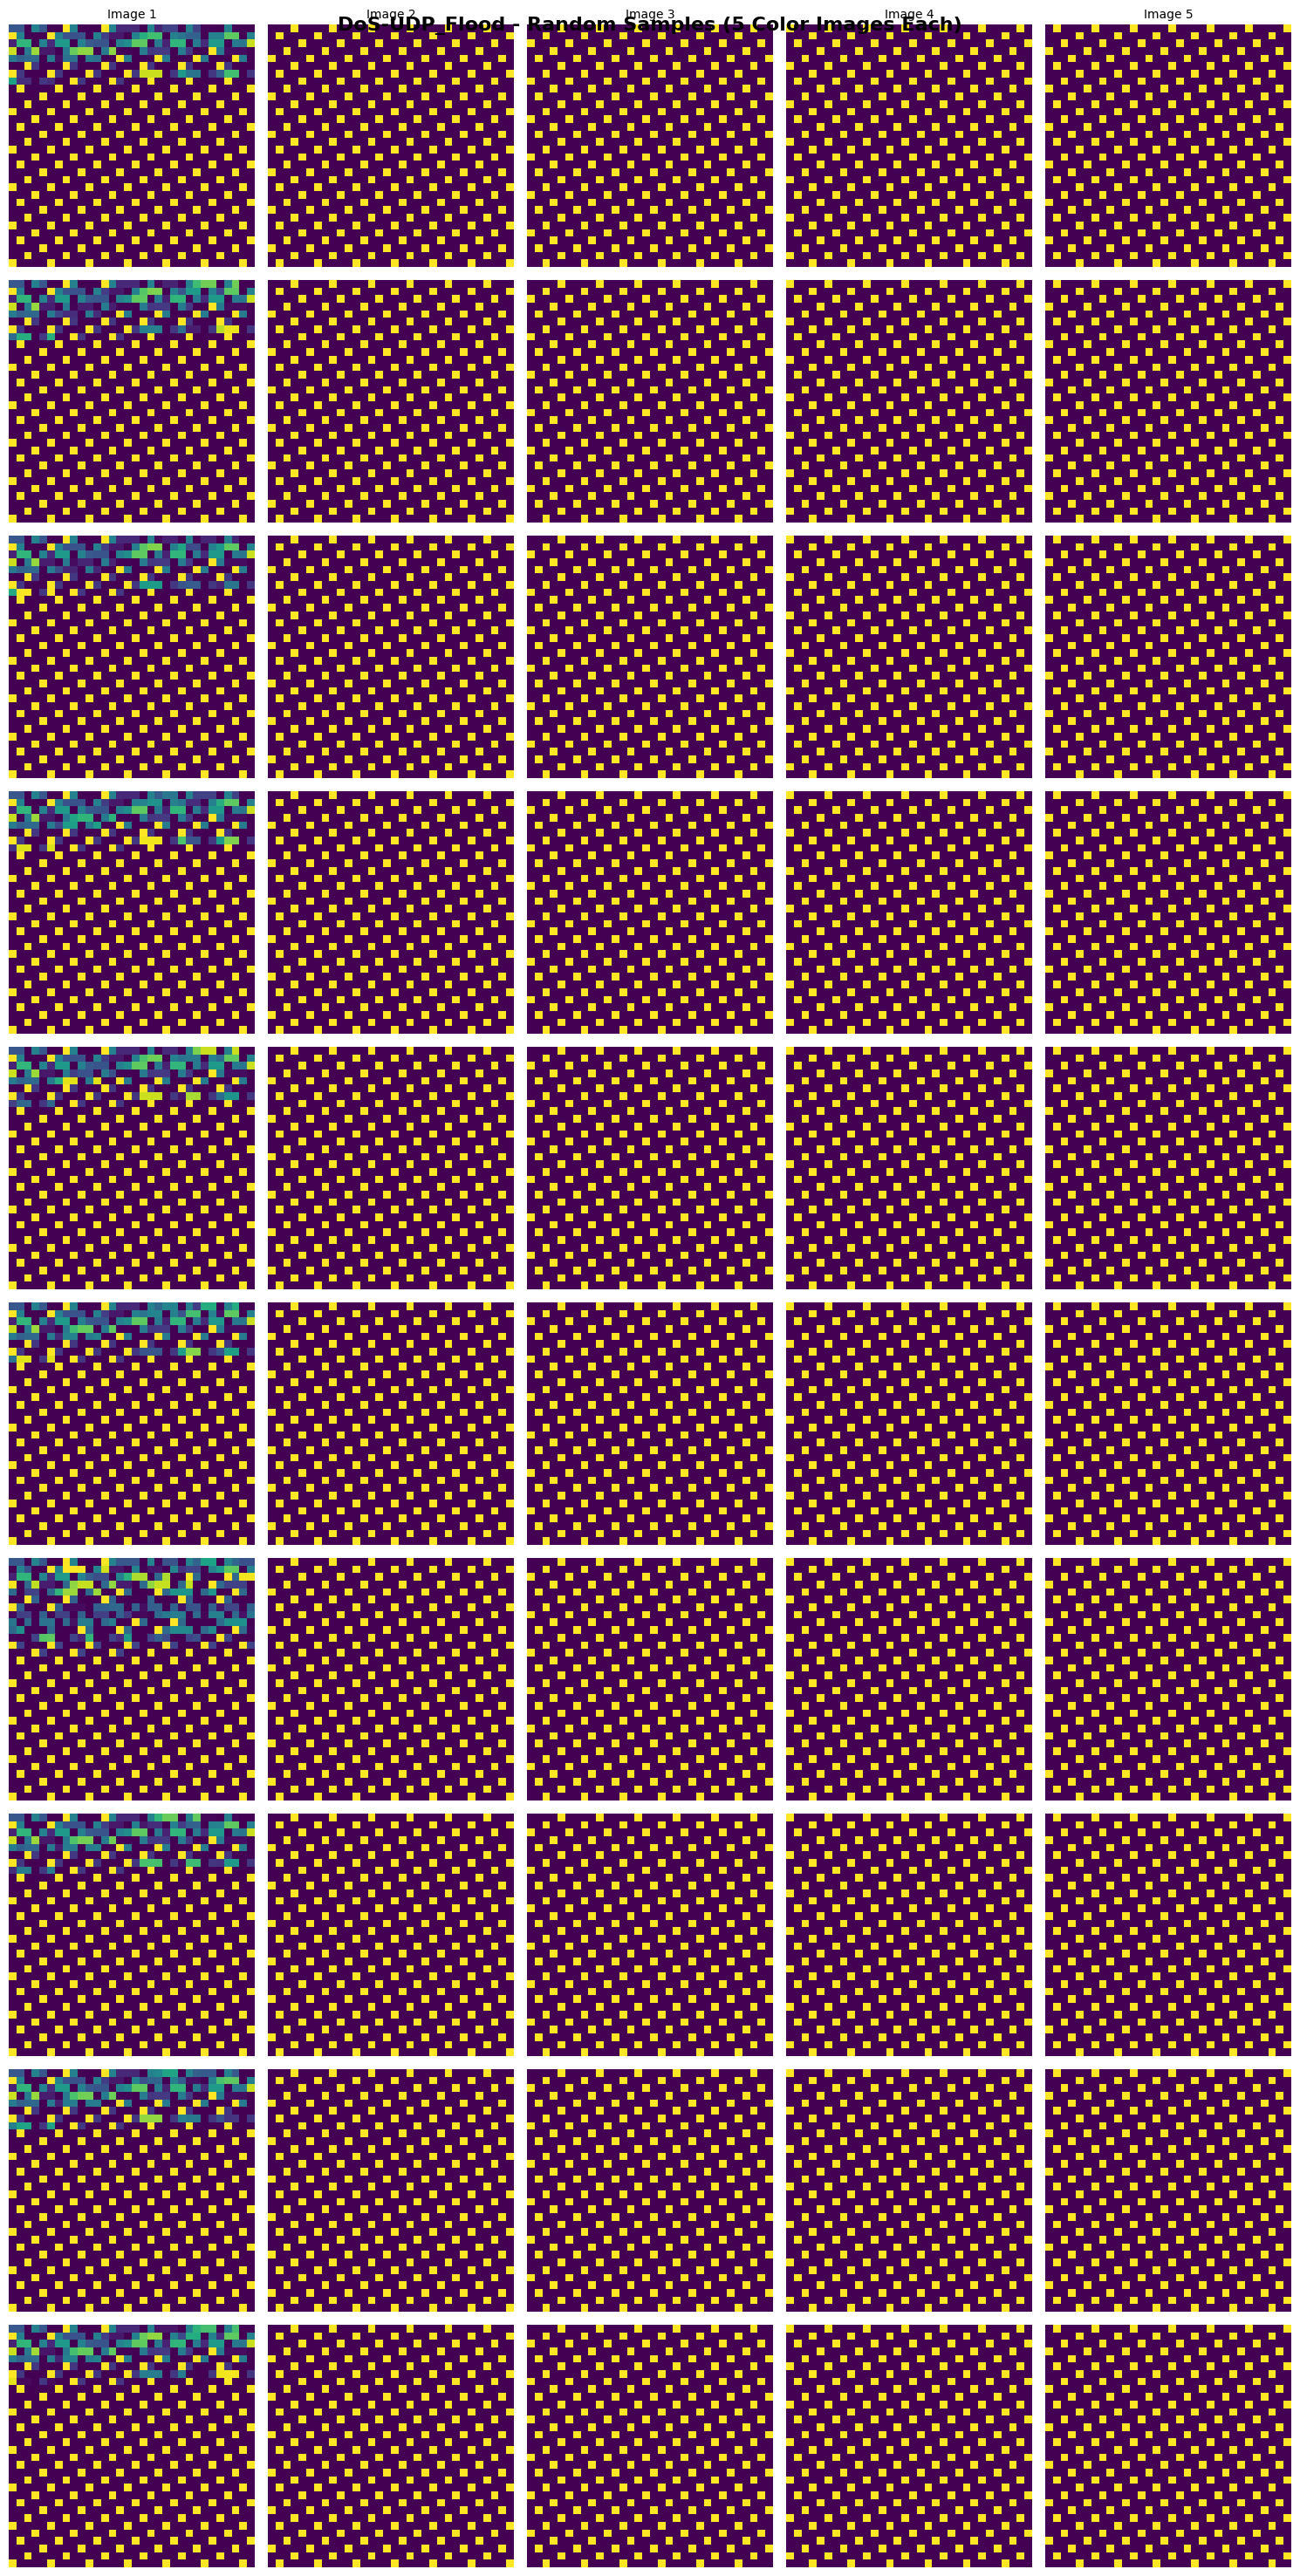

Displayed 10 samples with 5 color images each

Loading samples from class: Mirai-udpplain
Found 'image_data' column in Mirai-udpplain
Processing 'image_data' column for Mirai-udpplain
Loaded 10 samples with 5120 features each
Reshaped to: (10, 5, 32, 32)


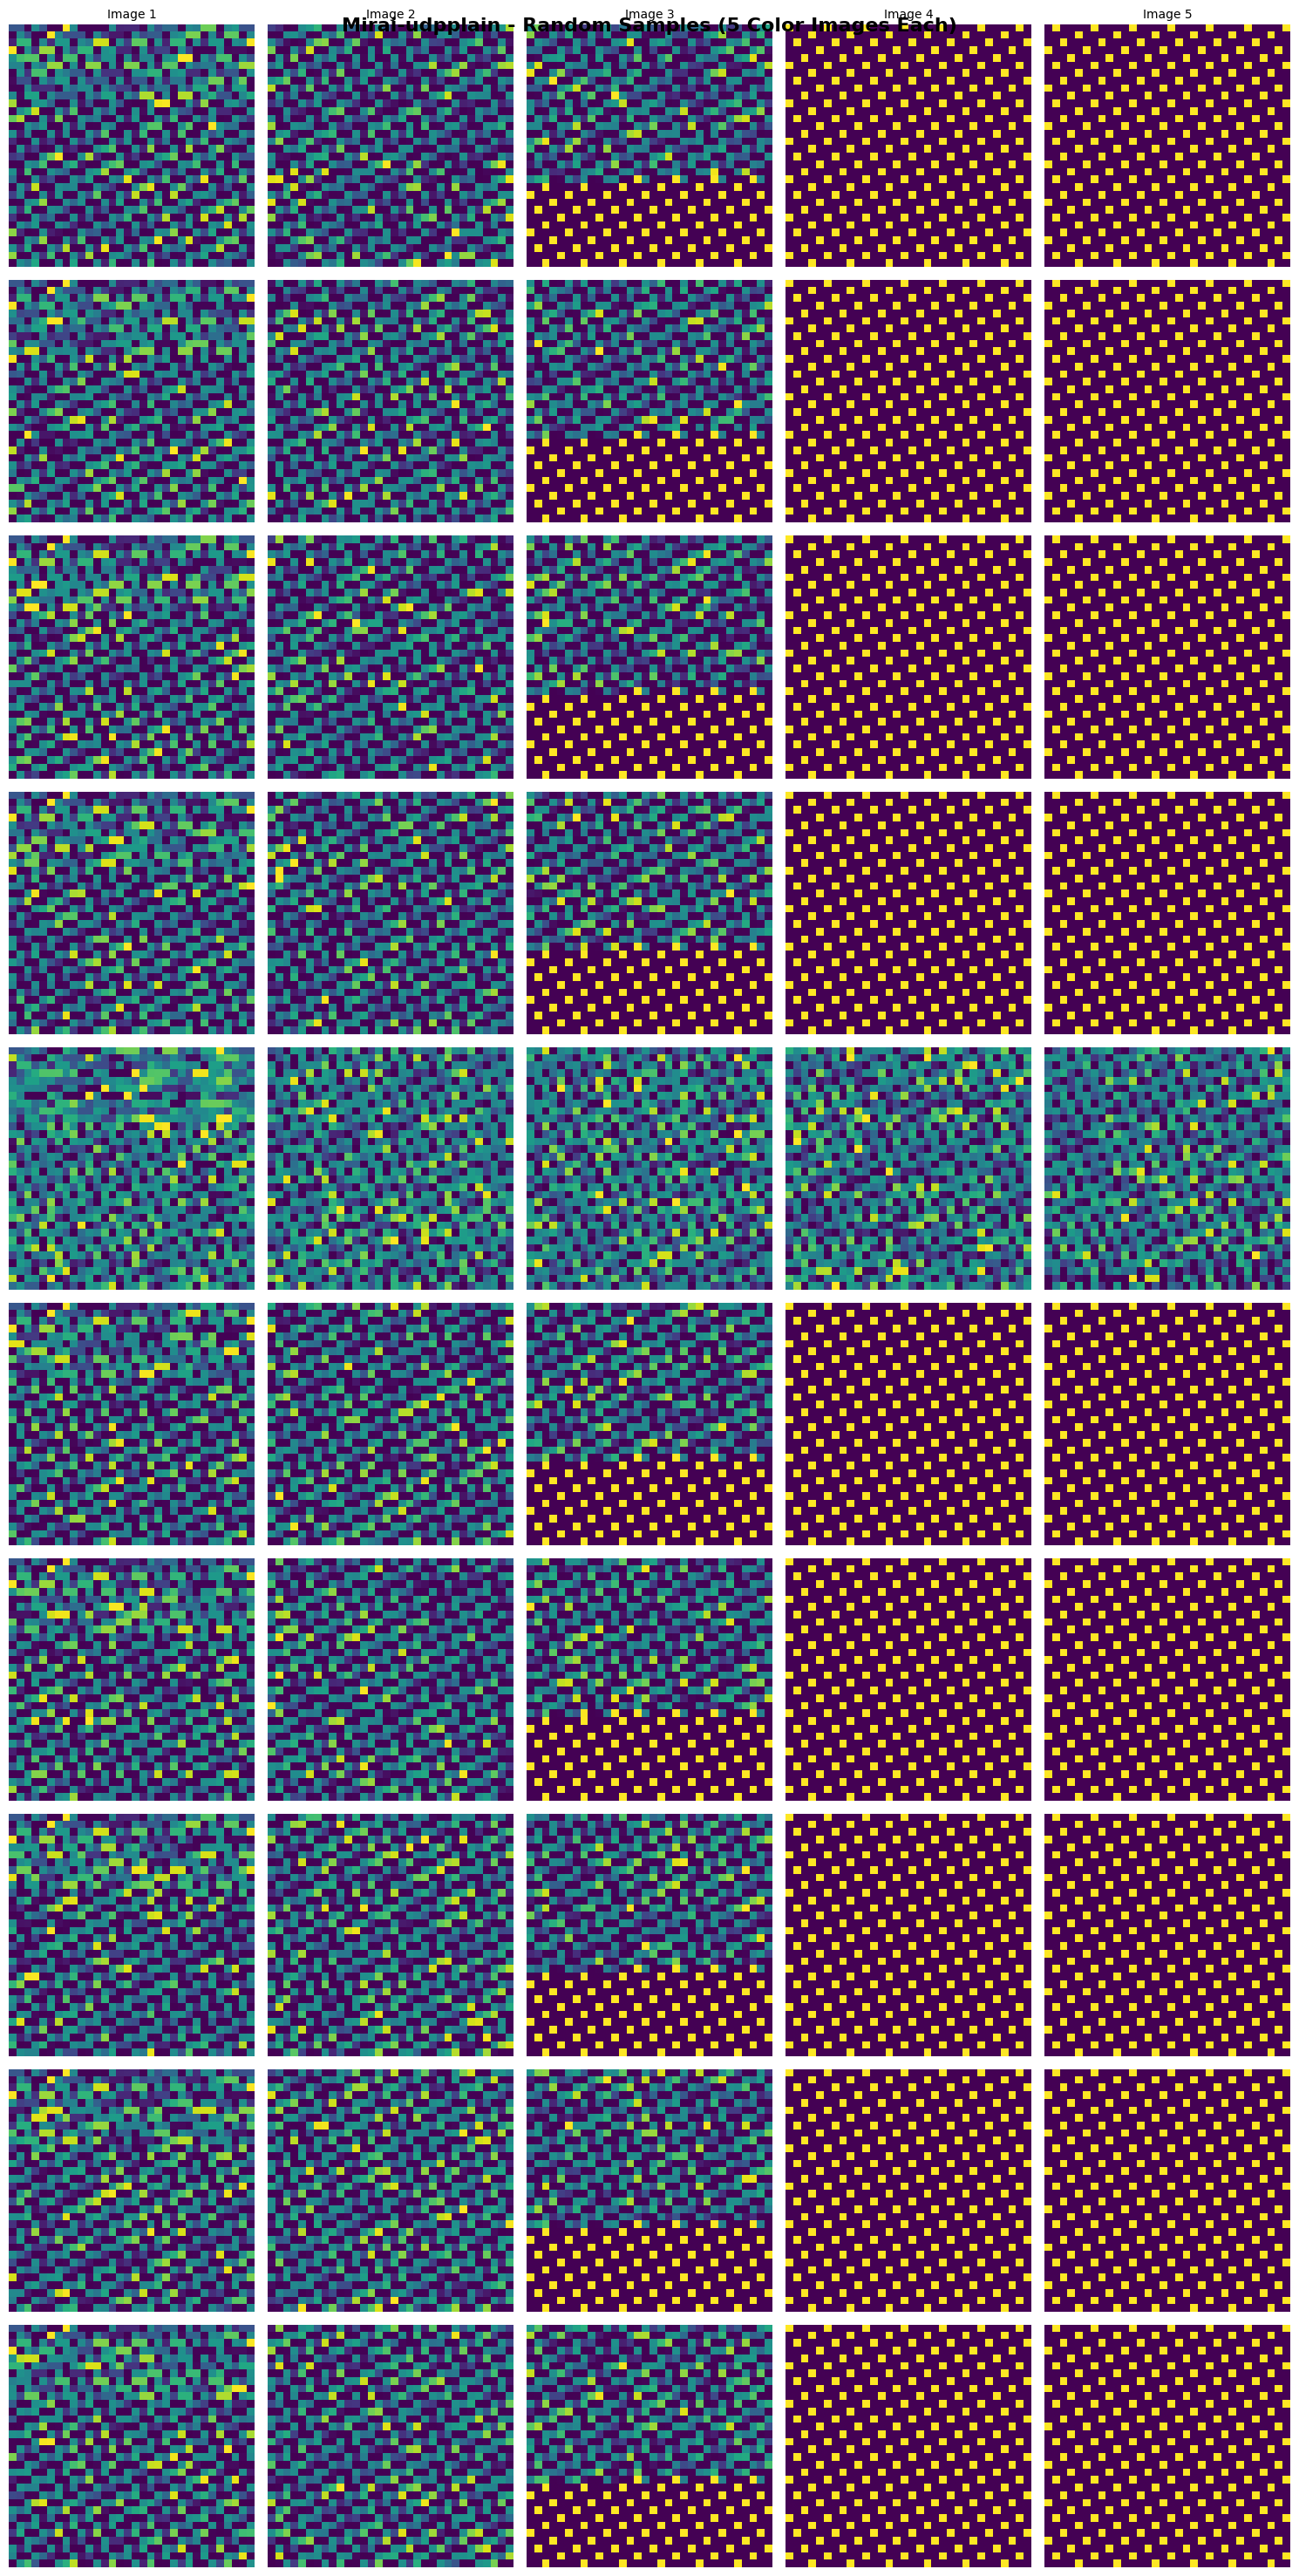

Displayed 10 samples with 5 color images each

Loading samples from class: Benign_Final
Found 'image_data' column in Benign_Final
Processing 'image_data' column for Benign_Final
Loaded 10 samples with 5120 features each
Reshaped to: (10, 5, 32, 32)


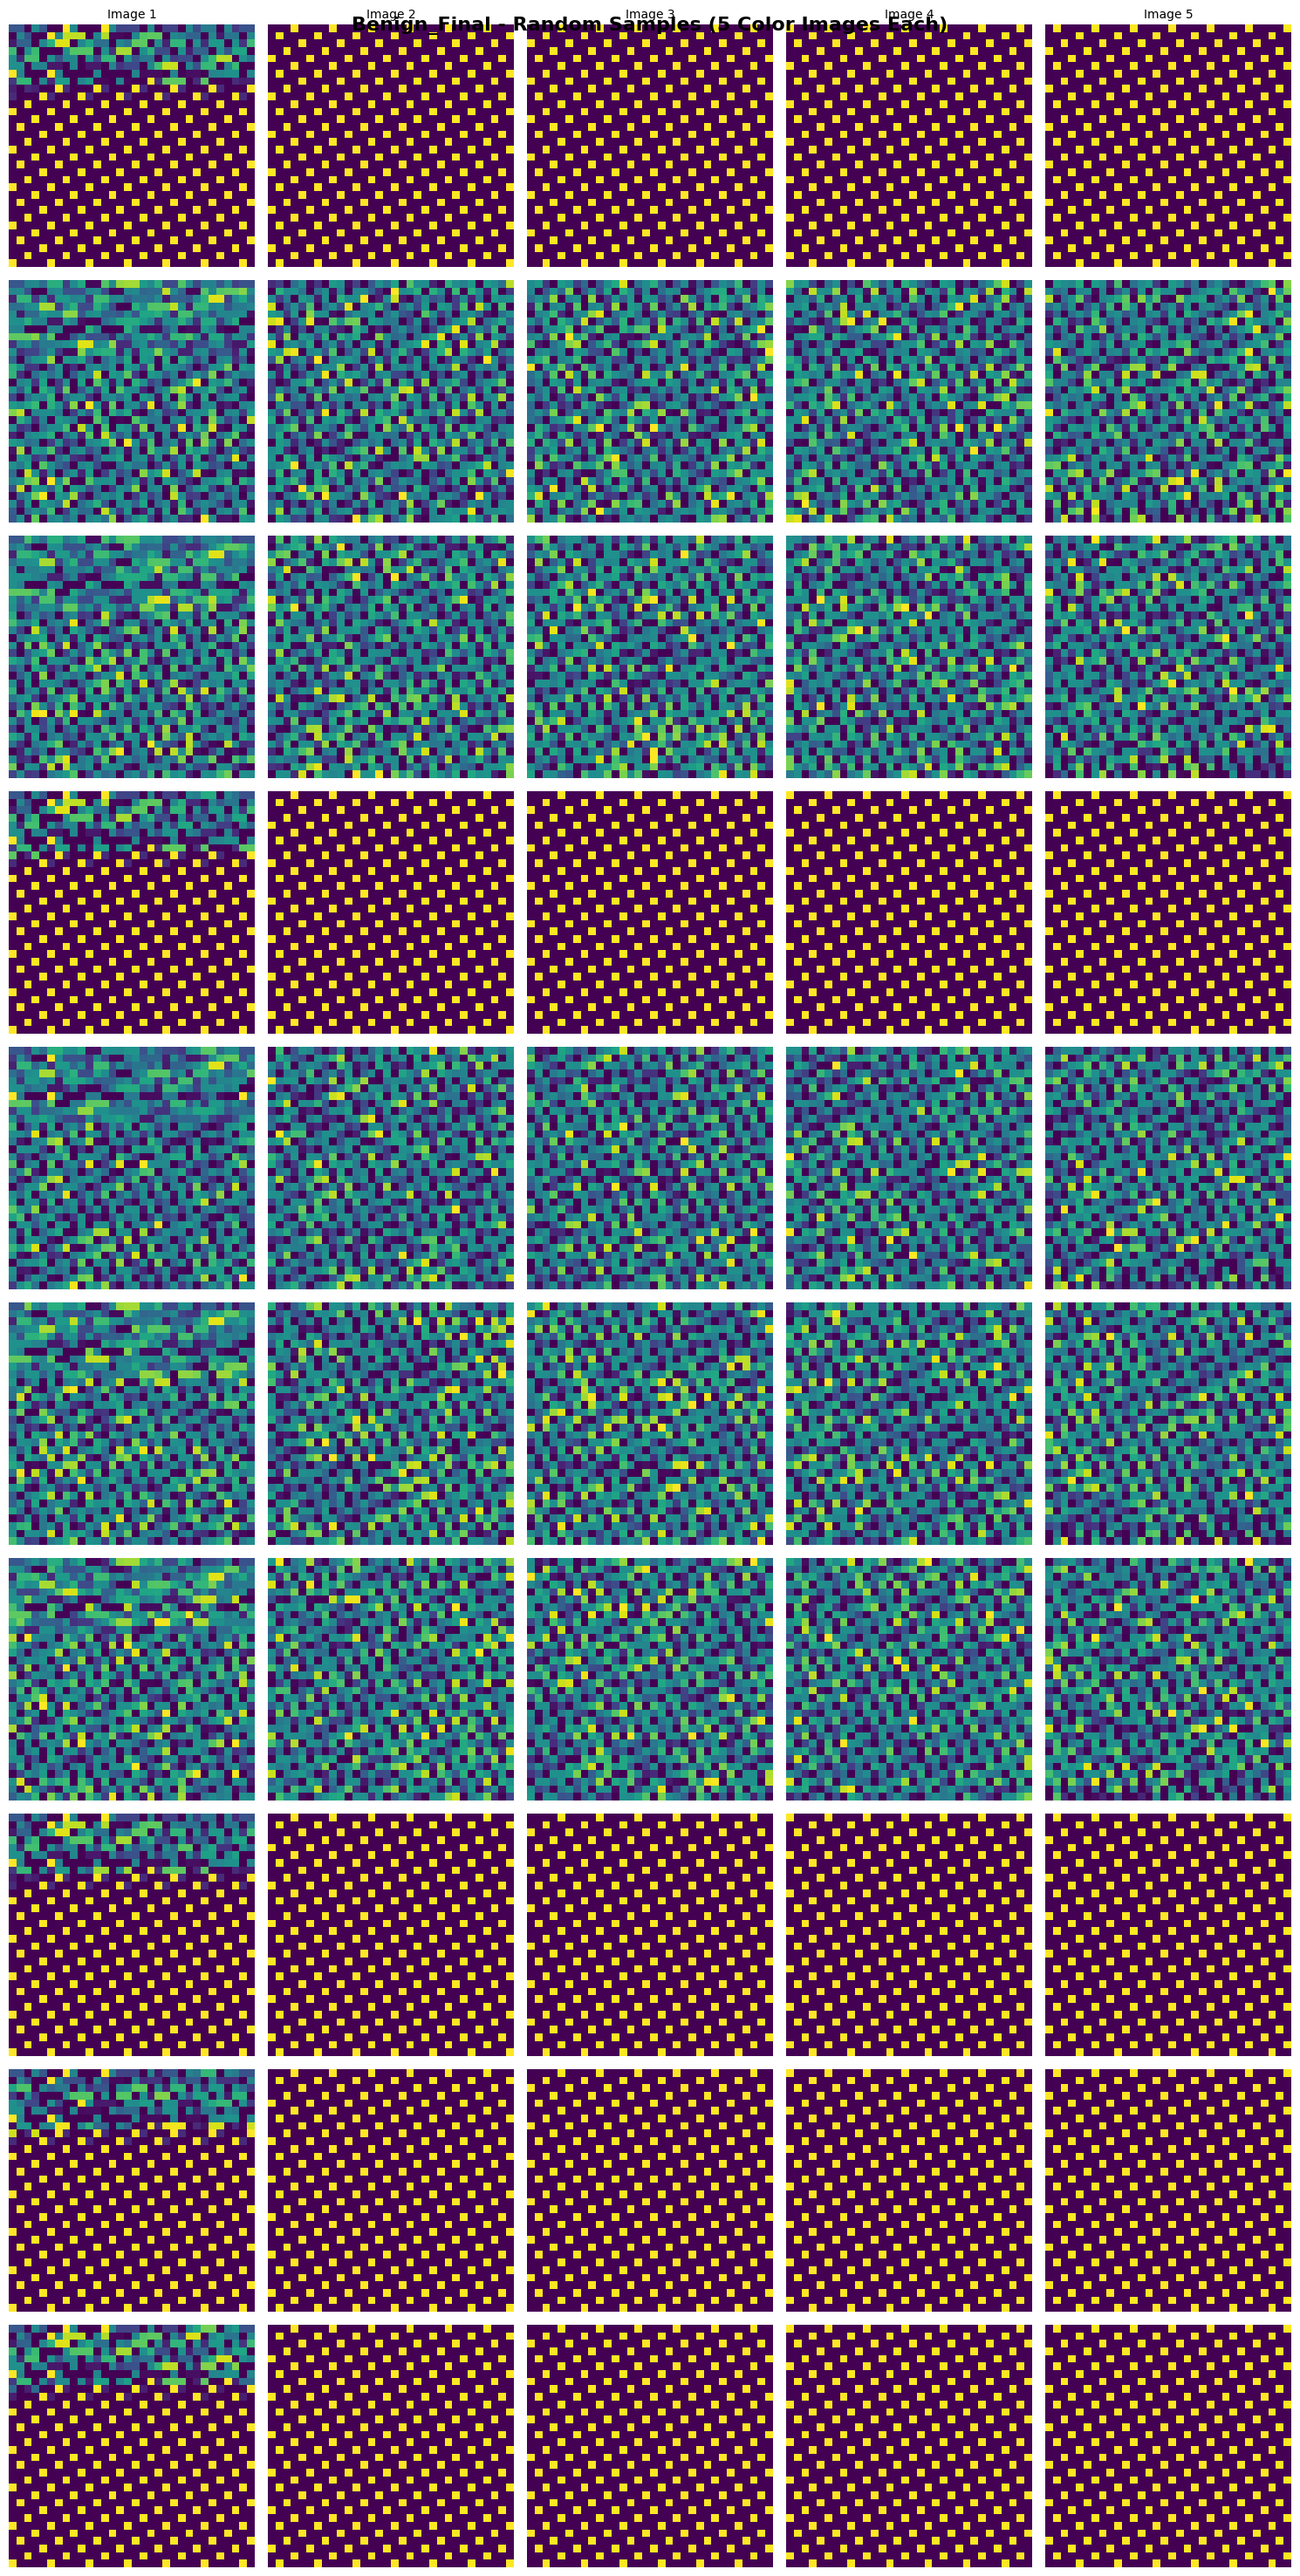

Displayed 10 samples with 5 color images each

Loading samples from class: SqlInjection
Found 'image_data' column in SqlInjection
Processing 'image_data' column for SqlInjection
Loaded 10 samples with 5120 features each
Reshaped to: (10, 5, 32, 32)


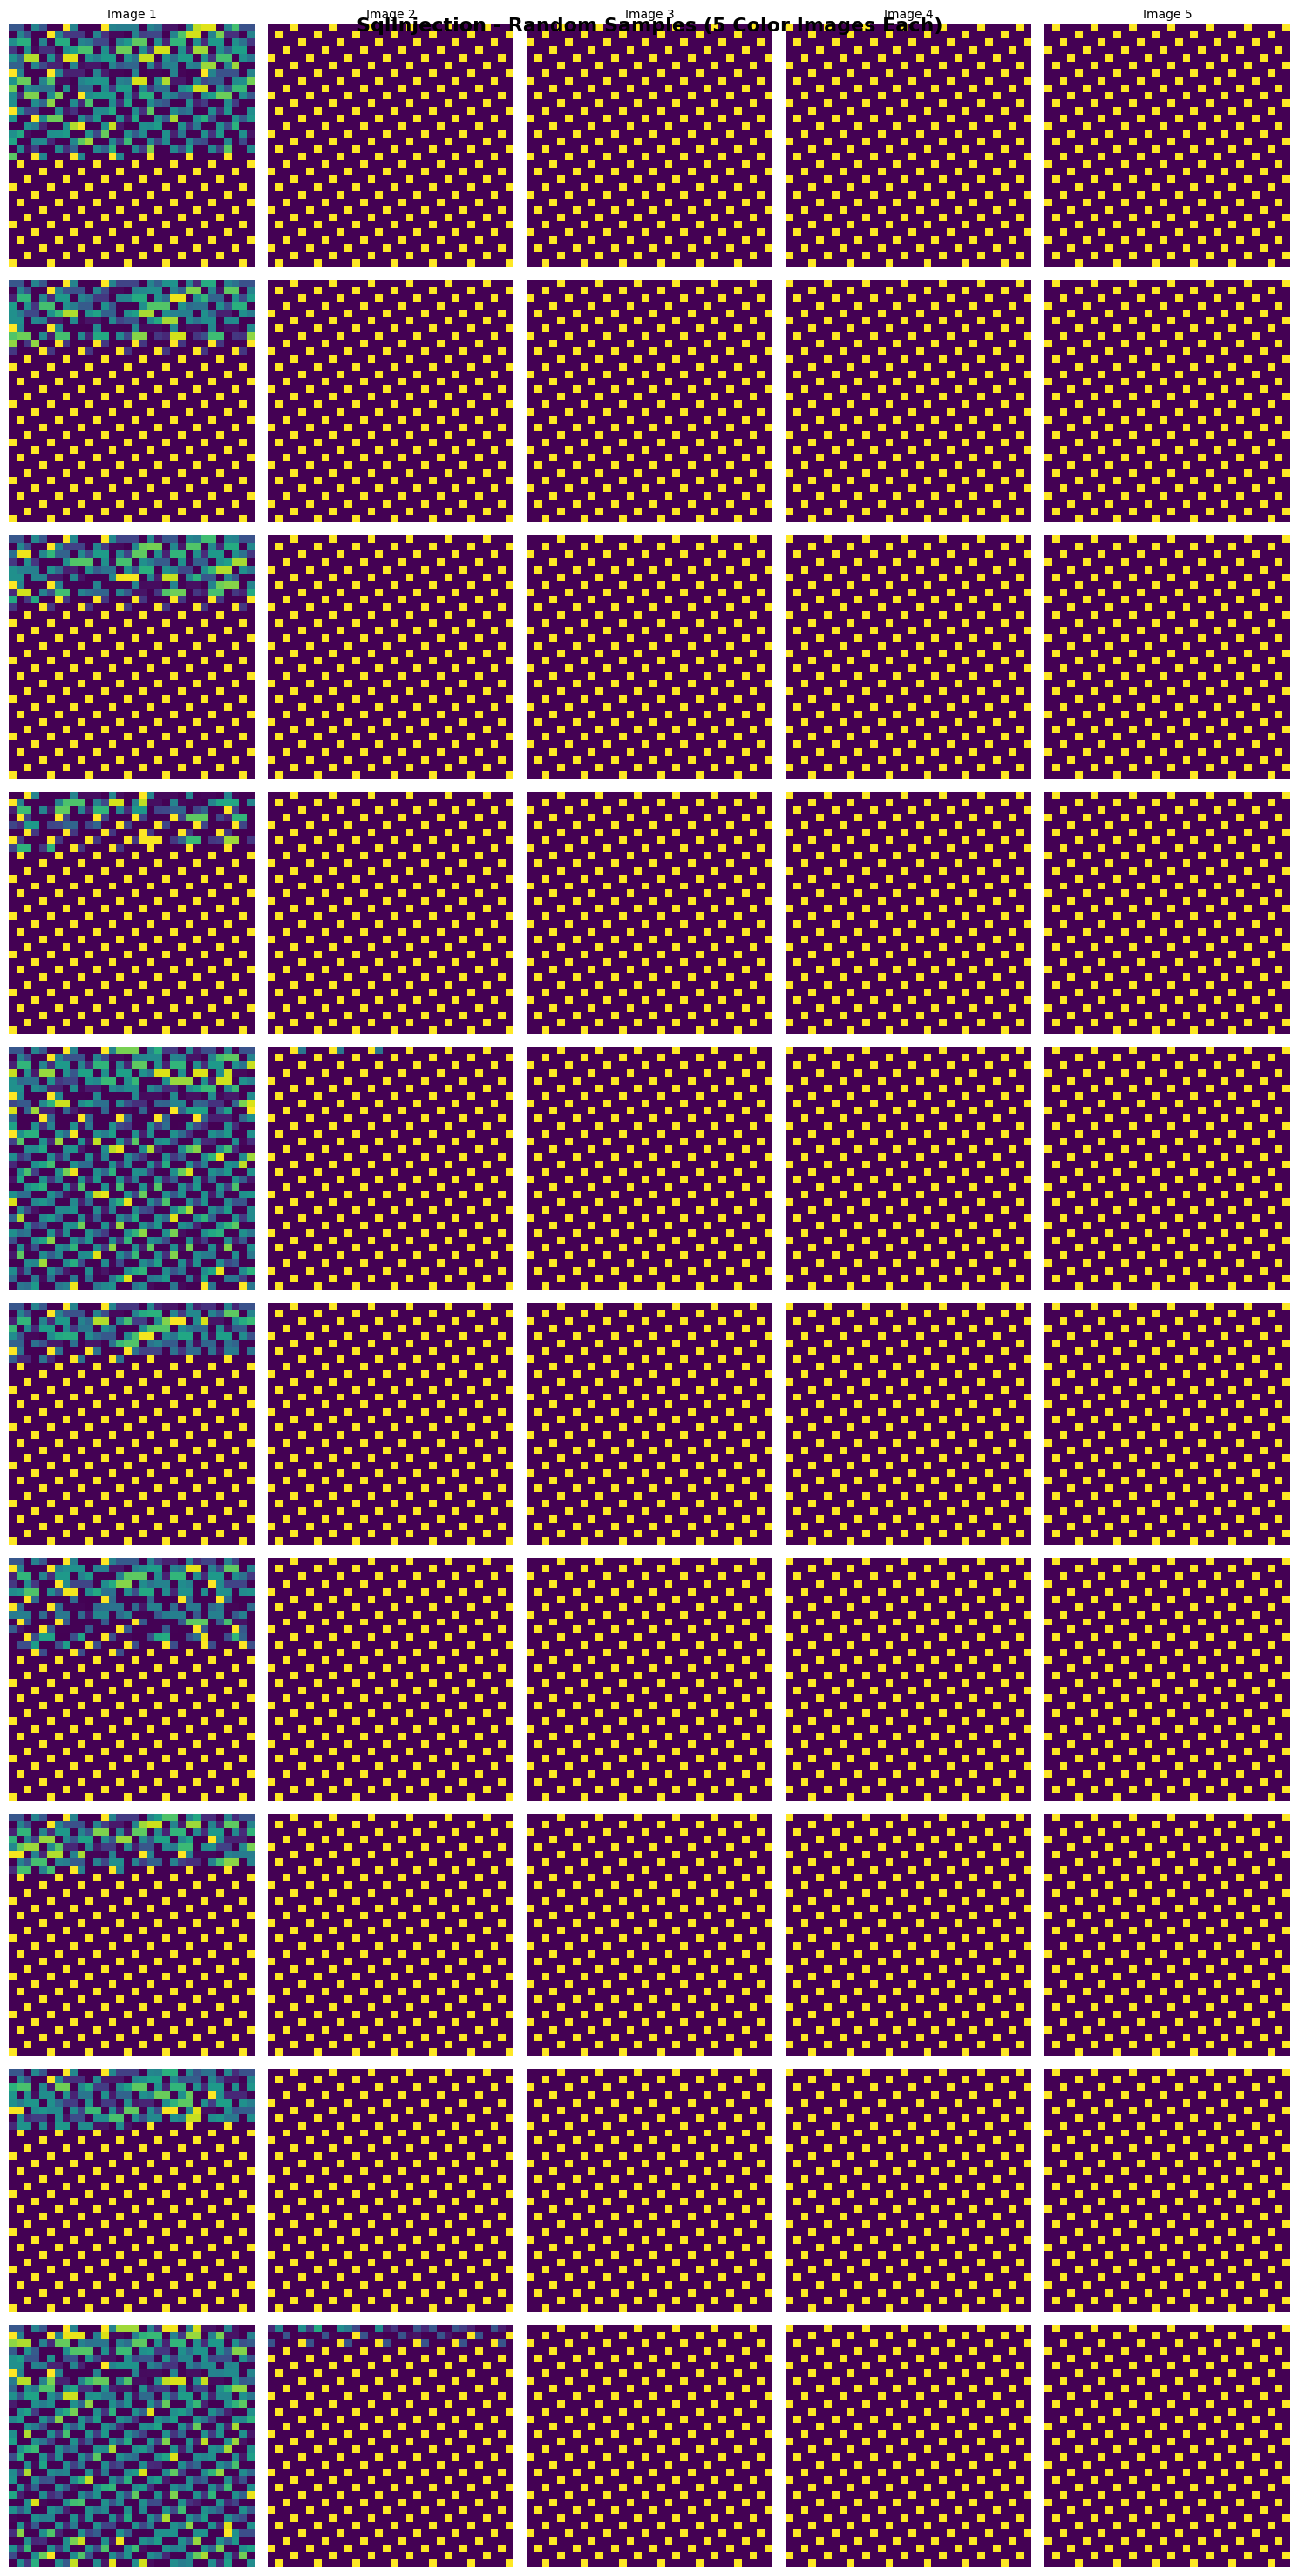

Displayed 10 samples with 5 color images each

Loading samples from class: DDoS-SYN_Flood
Found 'image_data' column in DDoS-SYN_Flood
Processing 'image_data' column for DDoS-SYN_Flood
Loaded 10 samples with 5120 features each
Reshaped to: (10, 5, 32, 32)


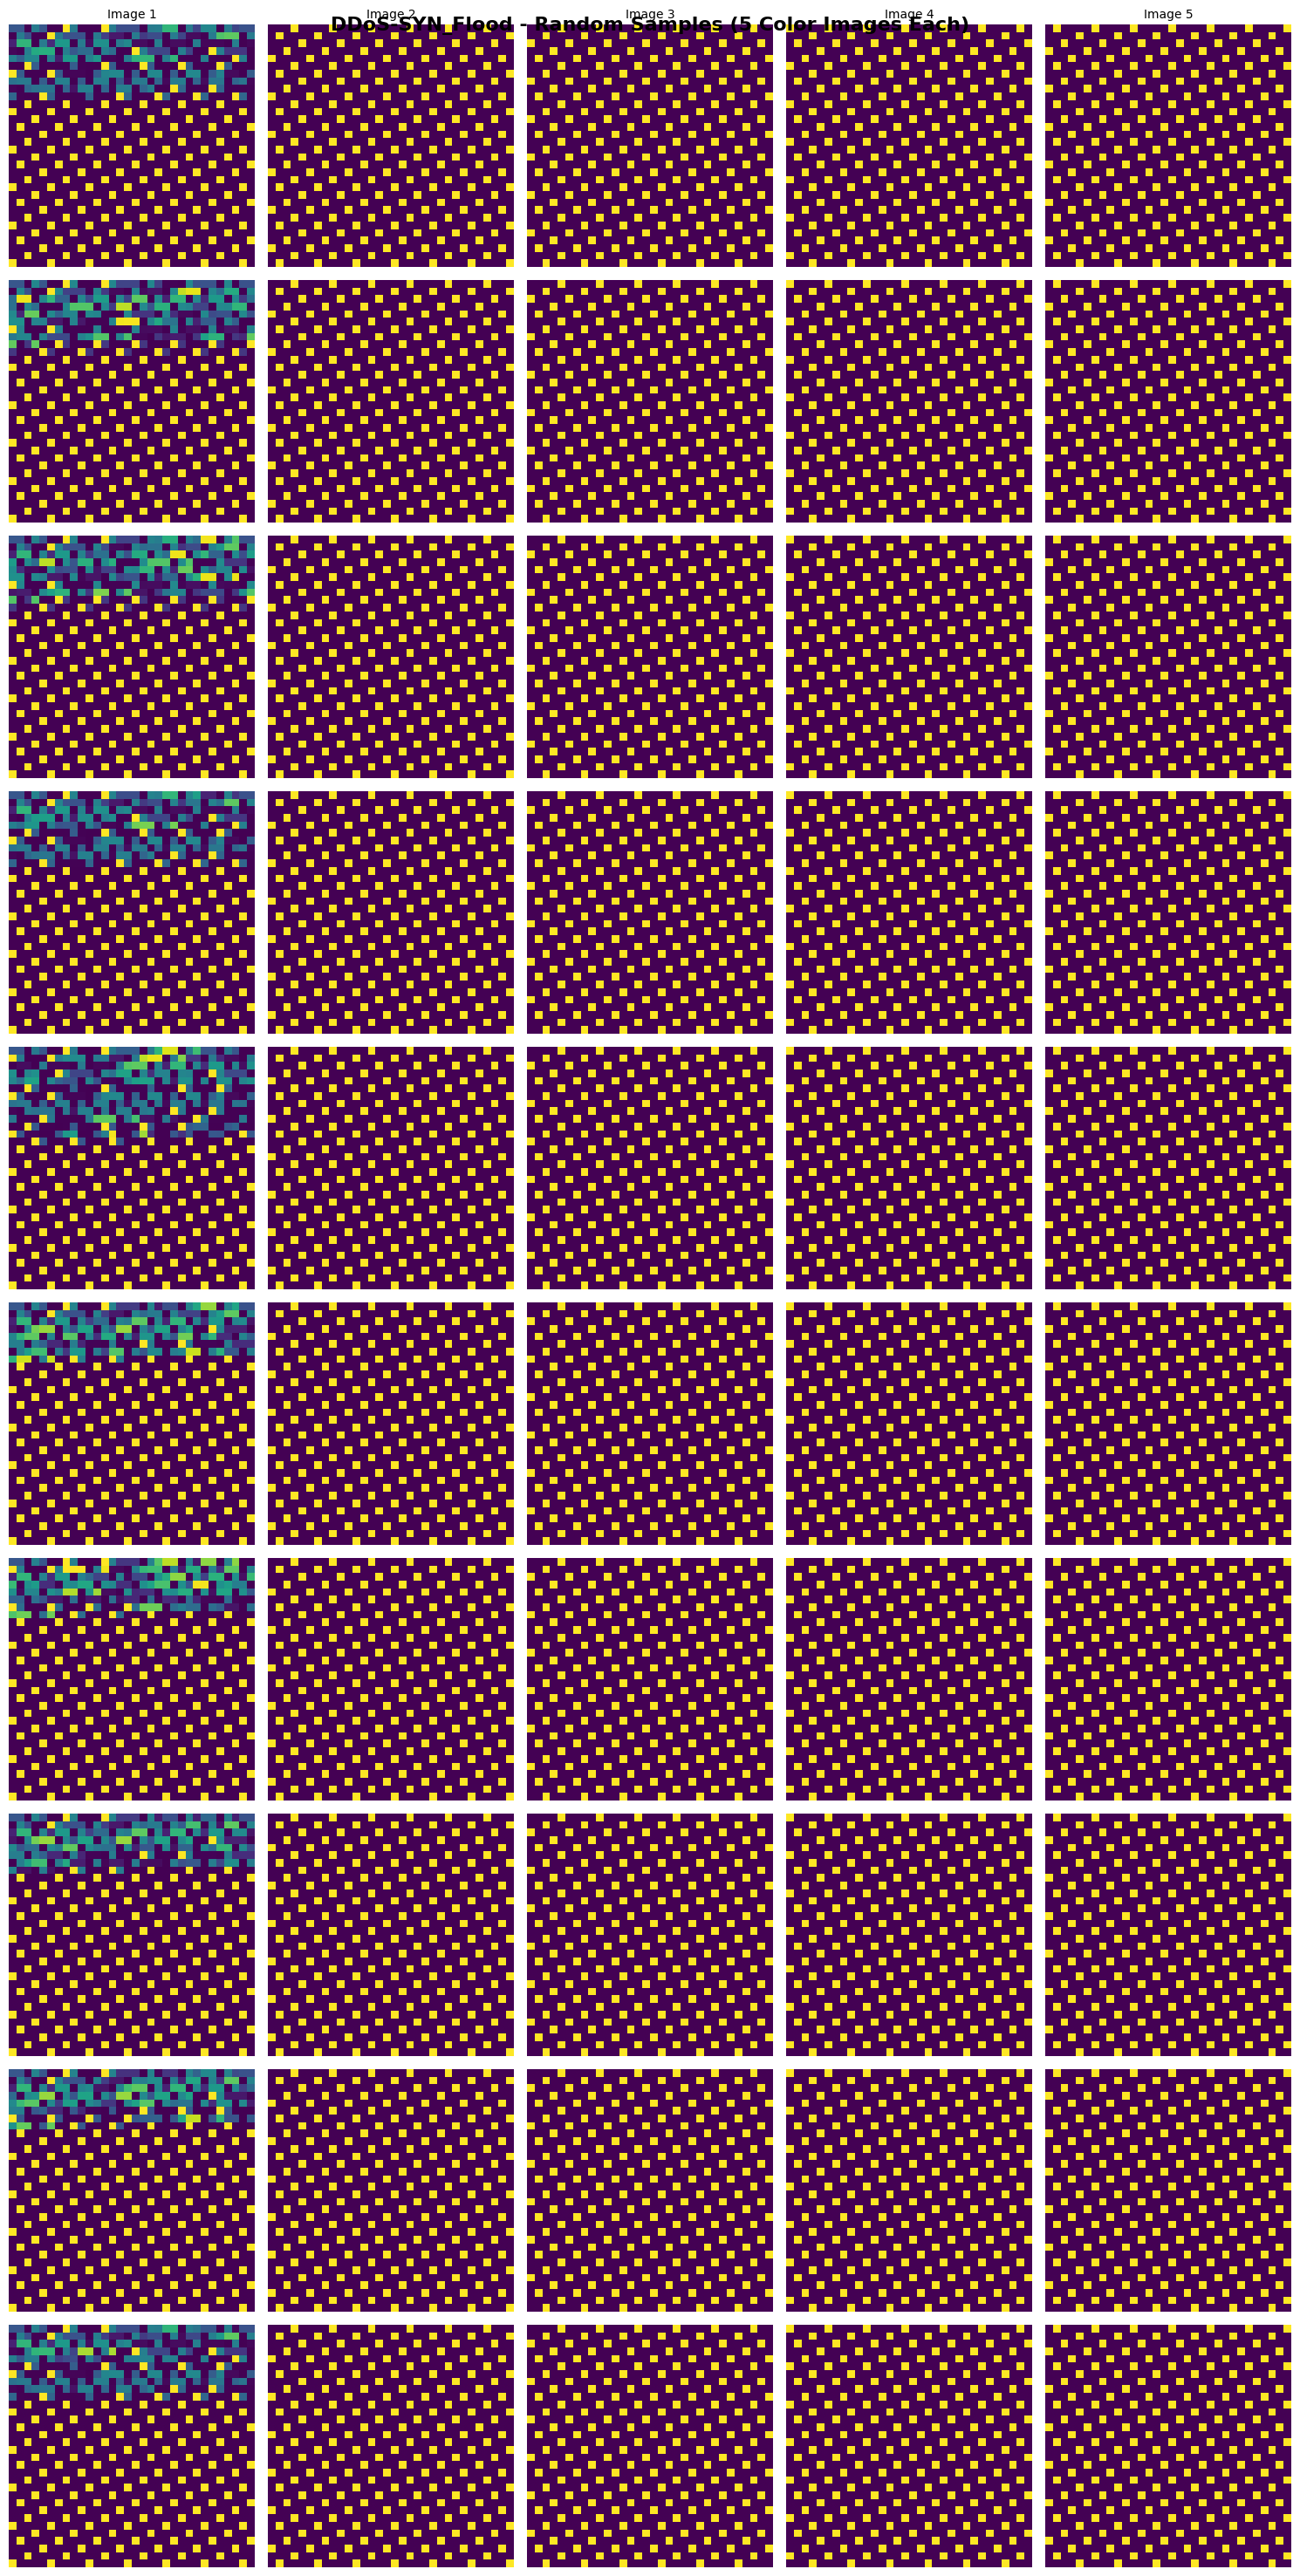

Displayed 10 samples with 5 color images each

Loading samples from class: DoS-TCP_Flood
Found 'image_data' column in DoS-TCP_Flood
Processing 'image_data' column for DoS-TCP_Flood
Loaded 10 samples with 5120 features each
Reshaped to: (10, 5, 32, 32)


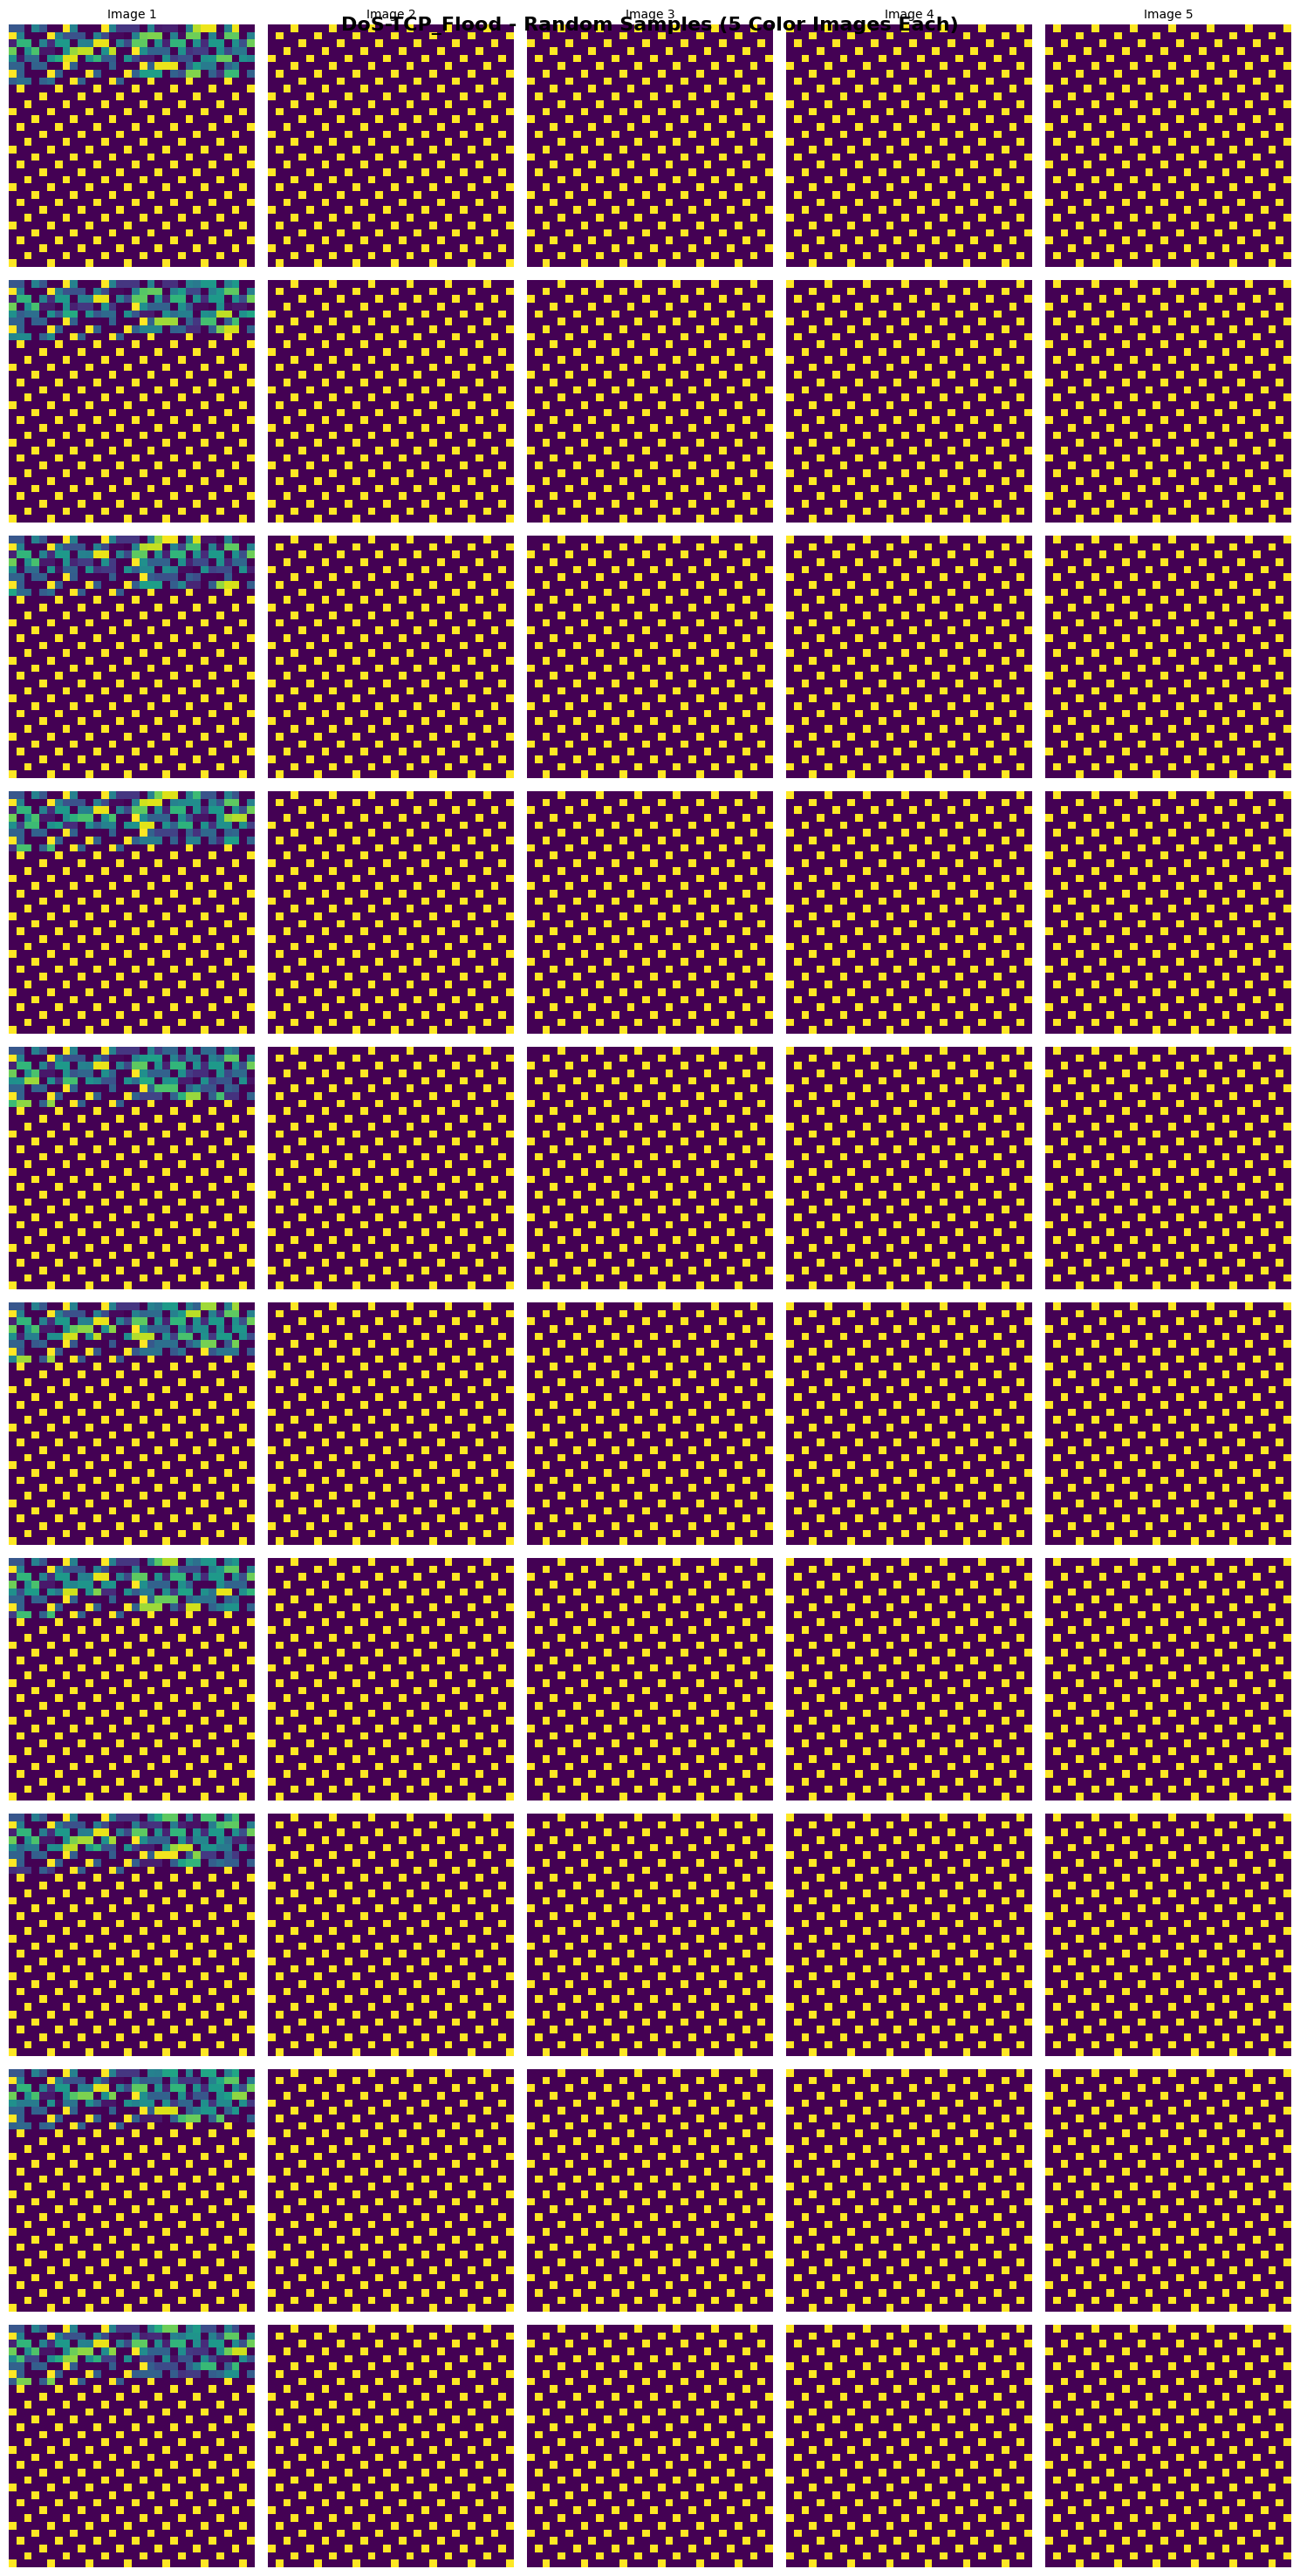

Displayed 10 samples with 5 color images each

Loading samples from class: DDoS-HTTP_Flood
Found 'image_data' column in DDoS-HTTP_Flood
Processing 'image_data' column for DDoS-HTTP_Flood
Loaded 10 samples with 5120 features each
Reshaped to: (10, 5, 32, 32)


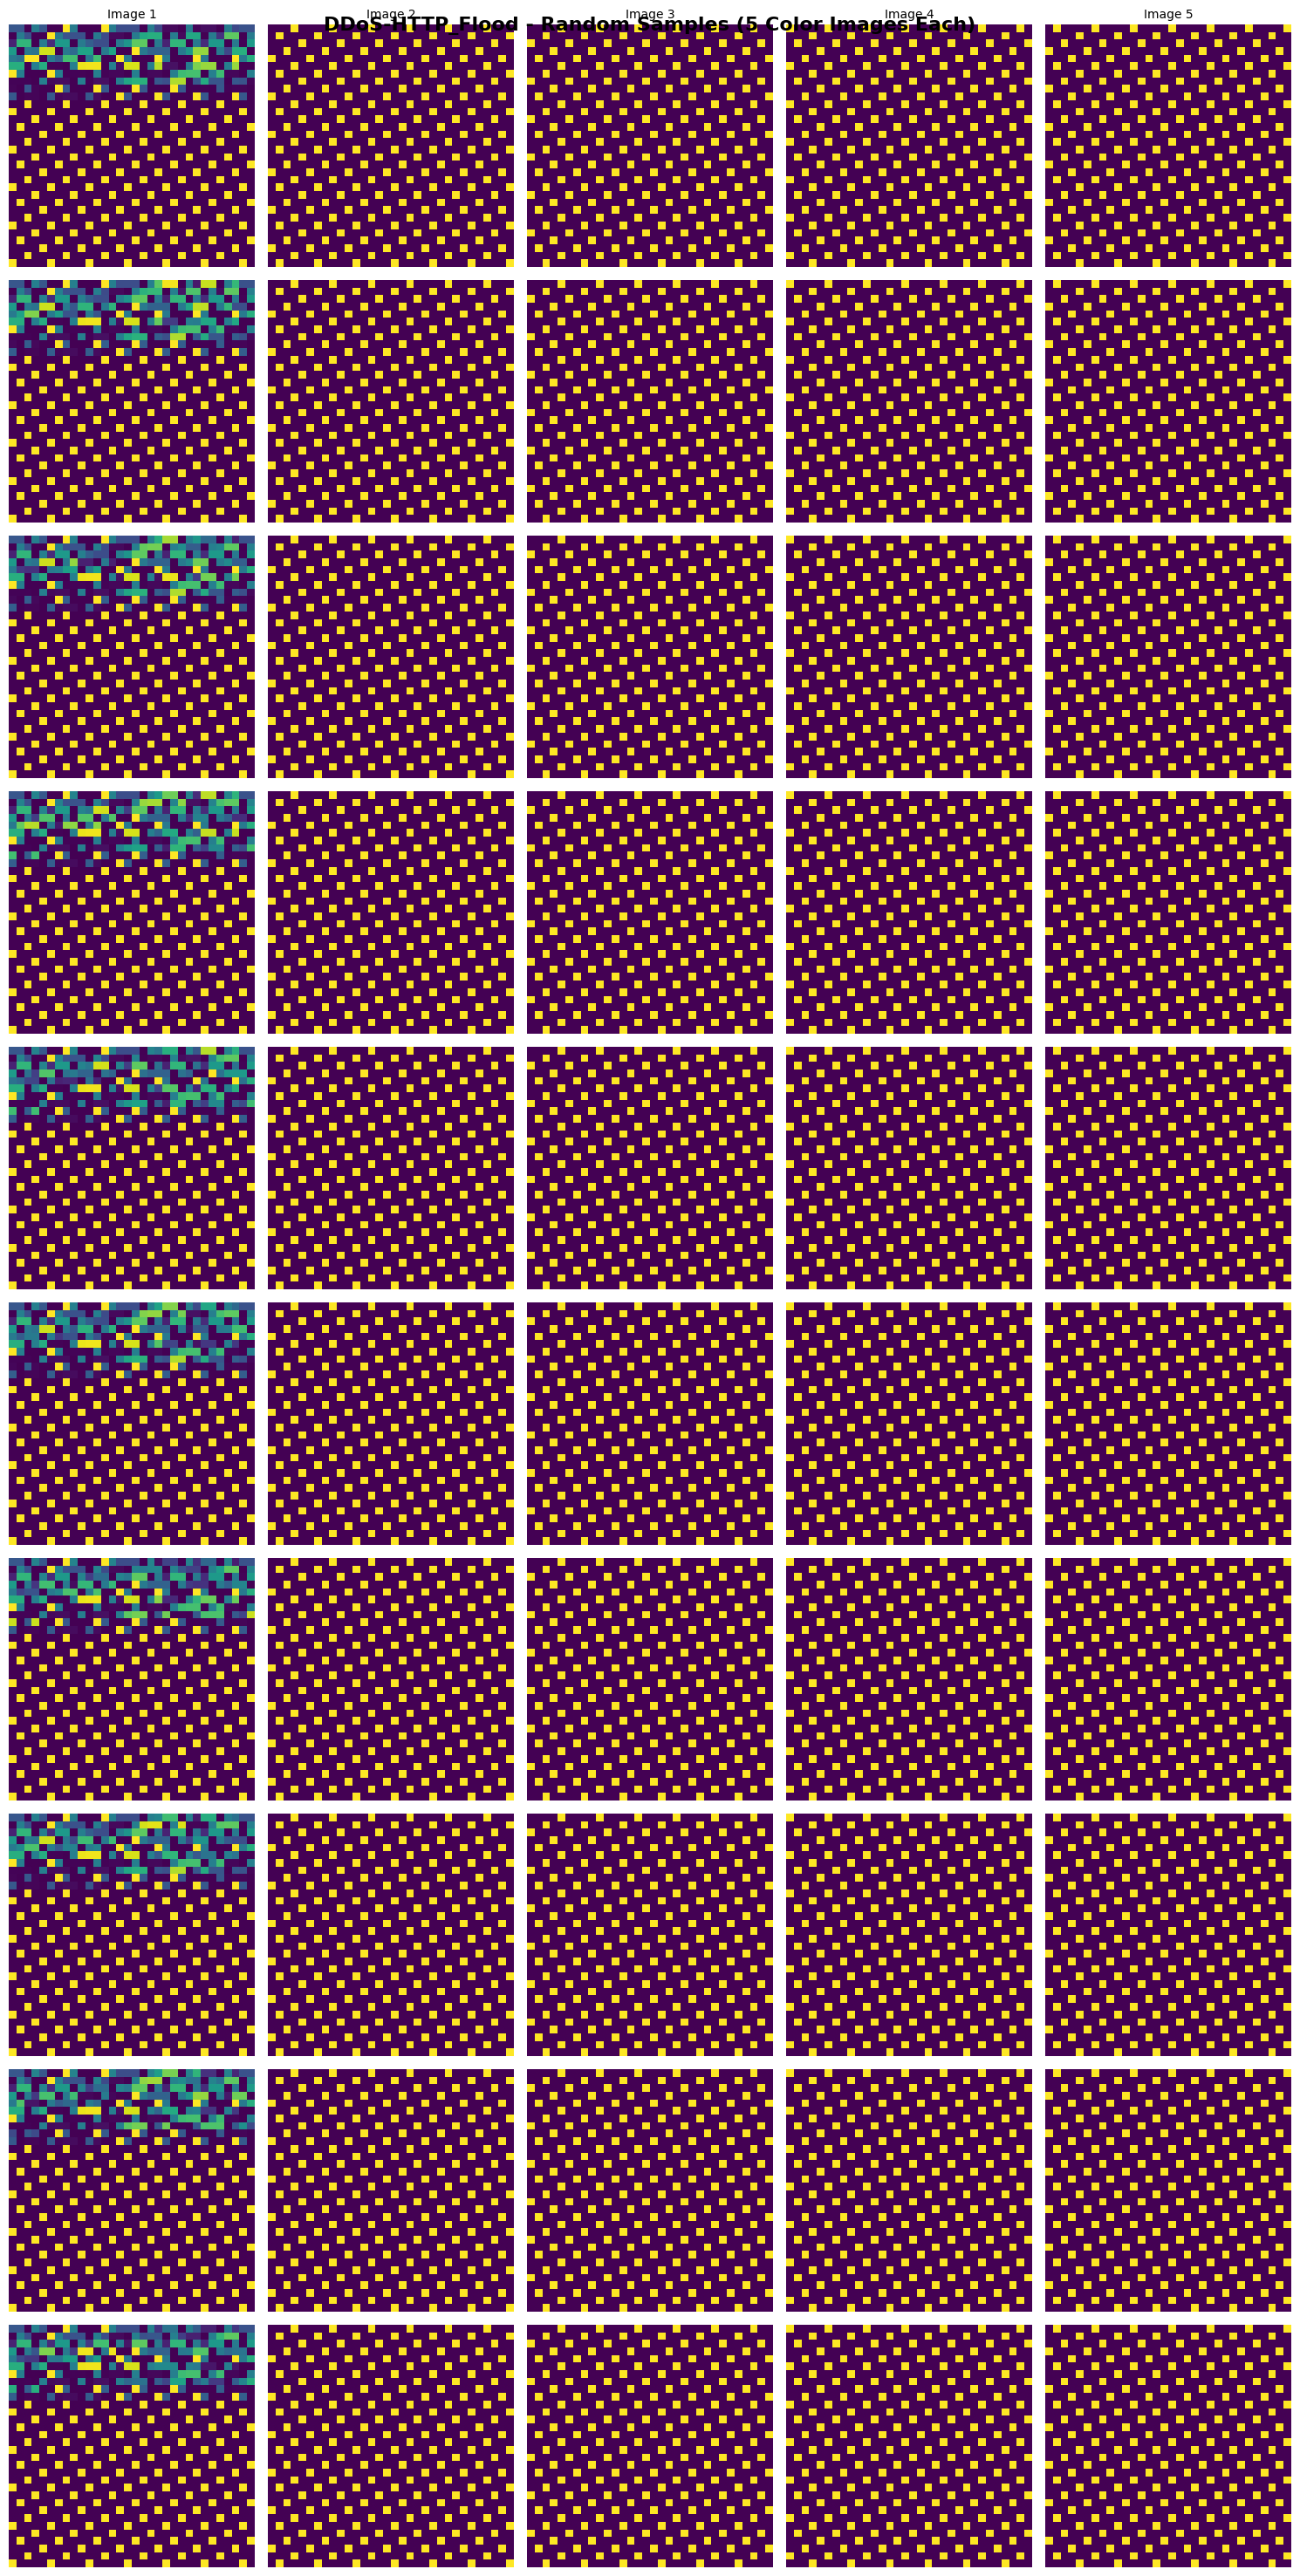

Displayed 10 samples with 5 color images each


In [7]:
# Display 10 random samples from each class - COLOR VERSION
for class_name in class_dirs:
    print(f"\n{'='*60}")
    print(f"Loading samples from class: {class_name}")
    print(f"{'='*60}")
    
    # Load sample data
    df = load_sample_data(class_name, num_samples=10)
    
    if not df.empty:
        # Check if we have 'image_data' column (like in ViT notebook)
        if 'image_data' in df.columns:
            print(f"Processing 'image_data' column for {class_name}")
            # Extract image data arrays
            image_data_list = []
            for idx, row in df.iterrows():
                image_array = np.array(row['image_data'], dtype=np.float32)
                image_data_list.append(image_array)
            
            image_data = np.array(image_data_list)
            print(f"Loaded {len(image_data)} samples with {image_data.shape[1]} features each")
            
            # Reshape to 5-channel 32x32 images
            if image_data.shape[1] == 5120:  # 5 * 32 * 32
                reshaped_data = image_data.reshape(-1, 5, 32, 32)
                print(f"Reshaped to: {reshaped_data.shape}")
                
                # Visualize samples - show each as 5 separate COLOR images
                num_samples_to_show = min(10, len(reshaped_data))
                fig, axes = plt.subplots(num_samples_to_show, 5, figsize=(15, 3*num_samples_to_show))
                fig.suptitle(f'{class_name} - Random Samples (5 Color Images Each)', fontsize=16, fontweight='bold')
                
                if num_samples_to_show == 1:
                    axes = axes.reshape(1, -1)
                
                for i in range(num_samples_to_show):
                    sample_image = reshaped_data[i]  # Shape: (5, 32, 32)
                    
                    for channel in range(5):
                        ax = axes[i, channel] if num_samples_to_show > 1 else axes[channel]
                        ax.imshow(sample_image[channel], cmap='viridis', aspect='auto')
                        if i == 0:
                            ax.set_title(f'Image {channel+1}', fontsize=10)
                        if channel == 0:
                            ax.set_ylabel(f'Sample {i+1}', fontsize=10)
                        ax.axis('off')
                
                plt.tight_layout()
                plt.show()
                print(f"Displayed {num_samples_to_show} samples with 5 color images each")
            else:
                print(f"Unexpected feature count: {image_data.shape[1]}, expected 5120")
        else:
            # Fallback: assume all numeric columns are features
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                image_data = df[numeric_cols].values
                print(f"Loaded {len(df)} samples with {len(numeric_cols)} features each (no 'image_data' column)")
                
                # Try to visualize assuming it's flattened 5120 features
                if image_data.shape[1] == 5120:
                    reshaped_data = image_data.reshape(-1, 5, 32, 32)
                    print(f"Reshaped to: {reshaped_data.shape}")
                    
                    # Visualize the samples with the color function
                    actual_samples = visualize_image_samples(image_data, class_name, num_samples=10)
                    print(f"Displayed {actual_samples} samples")
                else:
                    print(f"Cannot visualize: unexpected feature count {image_data.shape[1]}")
            else:
                print(f"No numeric data found for {class_name}")
    else:
        print(f"Failed to load data for class: {class_name}")

In [8]:
# Summary statistics
print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Total number of classes: {len(class_dirs)}")
print("\nClass names:")
for i, class_name in enumerate(class_dirs, 1):
    print(f"{i:2d}. {class_name}")


DATASET SUMMARY
Total number of classes: 9

Class names:
 1. Recon-PortScan
 2. DictionaryBruteForce
 3. DoS-UDP_Flood
 4. Mirai-udpplain
 5. Benign_Final
 6. SqlInjection
 7. DDoS-SYN_Flood
 8. DoS-TCP_Flood
 9. DDoS-HTTP_Flood
